<a href="https://colab.research.google.com/github/dokunoale/chagas/blob/dev/notebooks/base_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example usage of this project


The following notebook demonstrates how to install the required libraries for this project and then illustrates a basic usage example. It first checks the current TensorFlow version and then runs a simple computation using TensorFlow.

## Dataset and dependecies loading

In [ ]:
!git clone -b dev https://github.com/dokunoale/chagas.git
!pip install -q -r chagas/requirements.txt


# Download the dataset
import gdown
url = "https://drive.google.com/file/d/1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC/view?usp=drive_link"
gdown.download(url, "dataset.zip", quiet=False, fuzzy=True)
!unzip -q /content/dataset.zip -d chagas/data/

Cloning into 'chagas'...
remote: Enumerating objects: 617, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 617 (delta 84), reused 111 (delta 38), pack-reused 438 (from 1)
Receiving objects: 100% (617/617), 9.44 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (298/298), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 14.5 MB/s eta 0:00:00


Downloading...
From (original): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC
From (redirected): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC&confirm=t&uuid=a5ab6c94-db8d-430a-baf0-ae4cb5dceefb
To: /content/dataset.zip
100%|██████████| 623M/623M [00:09<00:00, 66.2MB/s]


In [ ]:
import sys
sys.path.append("/content/chagas/src")


import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

This code sets up the validation and test datasets for a Chagas disease classification task using ECG recordings. It begins by defining a custom noise reduction filter (`FiltfiltNoiseReducer`) with parameters tailored for ECG signals sampled at 400 Hz. Then, using a data loader (`WfdbLoader`), it applies the filter and loads ECG recordings labeled for the presence or absence of Chagas disease from specified directories. The data is shuffled during loading to ensure randomized batches. Finally, the metadata for the test set is retrieved for further analysis or tracking.


In [ ]:
from preprocessing.tf_dataset_loader import WfdbLoader
from preprocessing.filters import FiltfiltNoiseReducer


data_path = "/content/chagas/data/big_splitted_dataset/"

# Noise reduction filter
filter = FiltfiltNoiseReducer(fs=400, iir_freq=60.0, butterworth_cutoff=5., lowpass_cutoff=60., verbose=True)

# training set loading and preprocessing
train = WfdbLoader(label = 'Chagas label')
train.add_filter(filter)
train.add_dataset(data_path + "train/positives")
train.add_dataset(data_path + "train/negatives")
X_train, y_train = train.load(shuffle=True, verbose=True)

# validation set loading and preprocessing
validation = WfdbLoader(label = 'Chagas label')
validation.add_filter(filter)
validation.add_dataset(data_path + "val/positives")
validation.add_dataset(data_path + "val/negatives")
X_val, y_val = validation.load(shuffle=True, verbose=True)

# test set loading and preprocessing
test = WfdbLoader(label = 'Chagas label')
test.add_filter(filter)
test.add_dataset(data_path + "test/positives")
test.add_dataset(data_path + "test/negatives")
X_test, y_test = test.load(shuffle=True, verbose=True)

# Array of dictionaries with more info for model analysis
y_test_info = test.get_metadata()

Filtering records - filtfilt: 100%|██████████| 2245/2245 [00:13<00:00, 162.75record/s]


## Training

TODO: explain the model

In [ ]:
from models.layers import LightLogSpectrogram

@tf.keras.utils.register_keras_serializable()
class TemporalMeanPooling(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=2)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[3])

def build_cnn_model(input_shape=(2800, 12)):
    inputs = tf.keras.Input(shape=input_shape)  # 12-lead ECG time series

    # Logarithmic spectrogram
    x = LightLogSpectrogram()(inputs)  # shape: [batch, time, freq, 12]

    # Simple Conv2D block
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_32")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_64')(x)
    x = TemporalMeanPooling(name="temporal_pooling")(x)

    # GRU con 64 canali in input
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(32, return_sequences=True),
        merge_mode='ave',
        name='bigru_32_sequence'
    )(x)  # output: (batch, time, 32)

    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(32, return_sequences=False),
        merge_mode='ave',
        name='bigru_32'
    )(x)  # output: (batch, time, 32)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary output

    return tf.keras.Model(inputs, outputs, name="RCNN")

# Compiling
model = build_cnn_model(input_shape=(2800, 12))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

Model: "RCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2800, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ light_log_spectrogram           │ (None, 88, 64, 12)     │             0 │
│ (LightLogSpectrogram)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_32 (Conv2D)                │ (None, 88, 64, 32)     │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 44, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_64 (Conv2D)                │ (None, 44, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_pooling                │ (None, 44, 64)         │             0 │
│ (TemporalMeanPooling)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru_32_sequence               │ (None, 44, 32)         │        18,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru_32 (Bidirectional)        │ (None, 32)             │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,505 (209.00 KB)

 Trainable params: 53,505 (209.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback: early stopping and saving best model
early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_auc', mode='max', save_best_only=True)

callbacks = [early_stop, checkpoint]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=30,
    callbacks=callbacks
)

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.5029 - auc: 0.5118 - loss: 0.6946 - val_accuracy: 0.5018 - val_auc: 0.6089 - val_loss: 0.6908
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5601 - auc: 0.5853 - loss: 0.6817 - val_accuracy: 0.5918 - val_auc: 0.6698 - val_loss: 0.6614
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6419 - auc: 0.6911 - loss: 0.6355 - val_accuracy: 0.6569 - val_auc: 0.7145 - val_loss: 0.6246
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6699 - auc: 0.7280 - loss: 0.6063 - val_accuracy: 0.6783 - val_auc: 0.7503 - val_loss: 0.5983
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6776 - auc: 0.7454 - loss: 0.5958 - val_accuracy: 0.6916 - val_auc: 0.7710 - val_loss: 0.5981
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7056 - auc: 0.7758 - loss: 0.5684 - val_accuracy: 0.7157 - val_auc: 0.7945 - val_loss: 0.5575
Epoch 7/50
262/262 ━━━━━━━━━━━

## Model analysis

In [ ]:
from models.analysis import plot_training_metrics

# accuracy, AUC and loss plot
plot_training_metrics(history)

In [ ]:
from models.utils import find_optimal_threshold, compute_predictions
from sklearn.metrics import classification_report, accuracy_score
from models.layers import TemporalMeanPooling


# Load the trained Keras model from file, specifying any custom layers used
model = tf.keras.models.load_model(
    "bi_rcnn_1.keras",
    safe_mode=False,
    custom_objects={'TemporalMeanPooling': TemporalMeanPooling}
)

# Generate predicted probabilities on the validation set
y_pred_probs = model.predict(X_val)

# Find the optimal classification threshold based on the validation set
threshold = find_optimal_threshold(y_val, y_pred_probs)

# Compute final predictions, predicted classes, and correctness flags on the test set
y_pred, y_pred_classes, correct = compute_predictions(model, X_test, y_test, threshold)

# Print a detailed classification report (precision, recall, f1-score, support)
print(classification_report(y_test, y_pred_classes))

# Compute and store the overall accuracy score
accuracy = accuracy_score(y_test, y_pred_classes)
print(accuracy)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
Optimal threshold: 0.499
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1126
           1       0.72      0.78      0.75      1119

    accuracy                           0.74      2245
   macro avg       0.74      0.74      0.74      2245
weighted avg       0.74      0.74      0.74      2245



36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Optimal threshold: 0.499
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


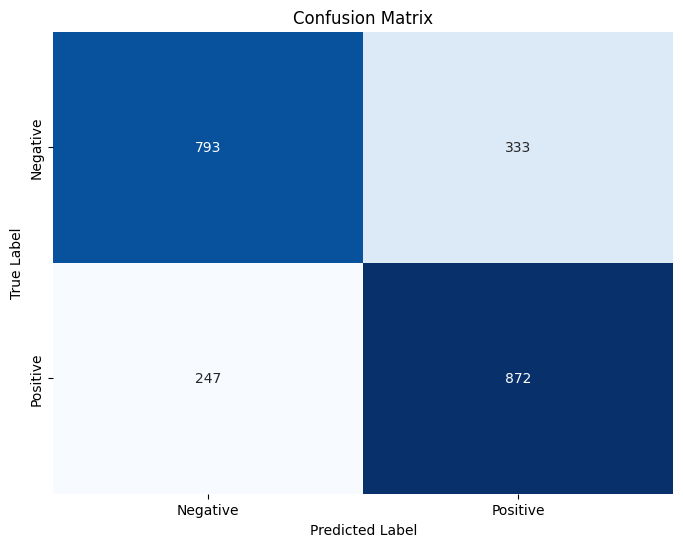

In [ ]:
from models.analysis import plot_confusion_matrix


# Confusion matrix
plot_confusion_matrix(y_test, y_pred_classes)

The next cell provides a summary of the distribution of the model's output scores.

- **Distribution of predictions**: Displays the distribution of predicted probabilities, highlighting correct (blue) and incorrect (red) classifications. A vertical dashed line indicates the 0.5 threshold, which may vary depending on the decision criterion.

- **Source distribution by model output**: Shows how the model's output scores (x-axis) are distributed across subgroups defined by data origin and label. This allows us to assess how different dataset segments are classified and to detect potential imbalances. Groups include:

    - Chagas-negative cases from CODE-15% (light teal),

    - Chagas-positive cases from CODE-15% (teal),

    - Chagas-positive cases from SaMi-Trop (yellow).

- **Age distribution for correct predictions**: Depicts the distribution of model outputs for correctly classified samples, stratified by age group. This provides insight into how prediction confidence varies across age.

- **Age distribution for incorrect predictions**: Analogous to the previous chart but focused on misclassifications. It helps identify age groups with higher error rates or ambiguous outputs.

- **Prediction success rate by age**: Summarizes the model's classification accuracy by age group, expressed as a percentage of correct predictions. Sample counts per group are reported above each bar for context.

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


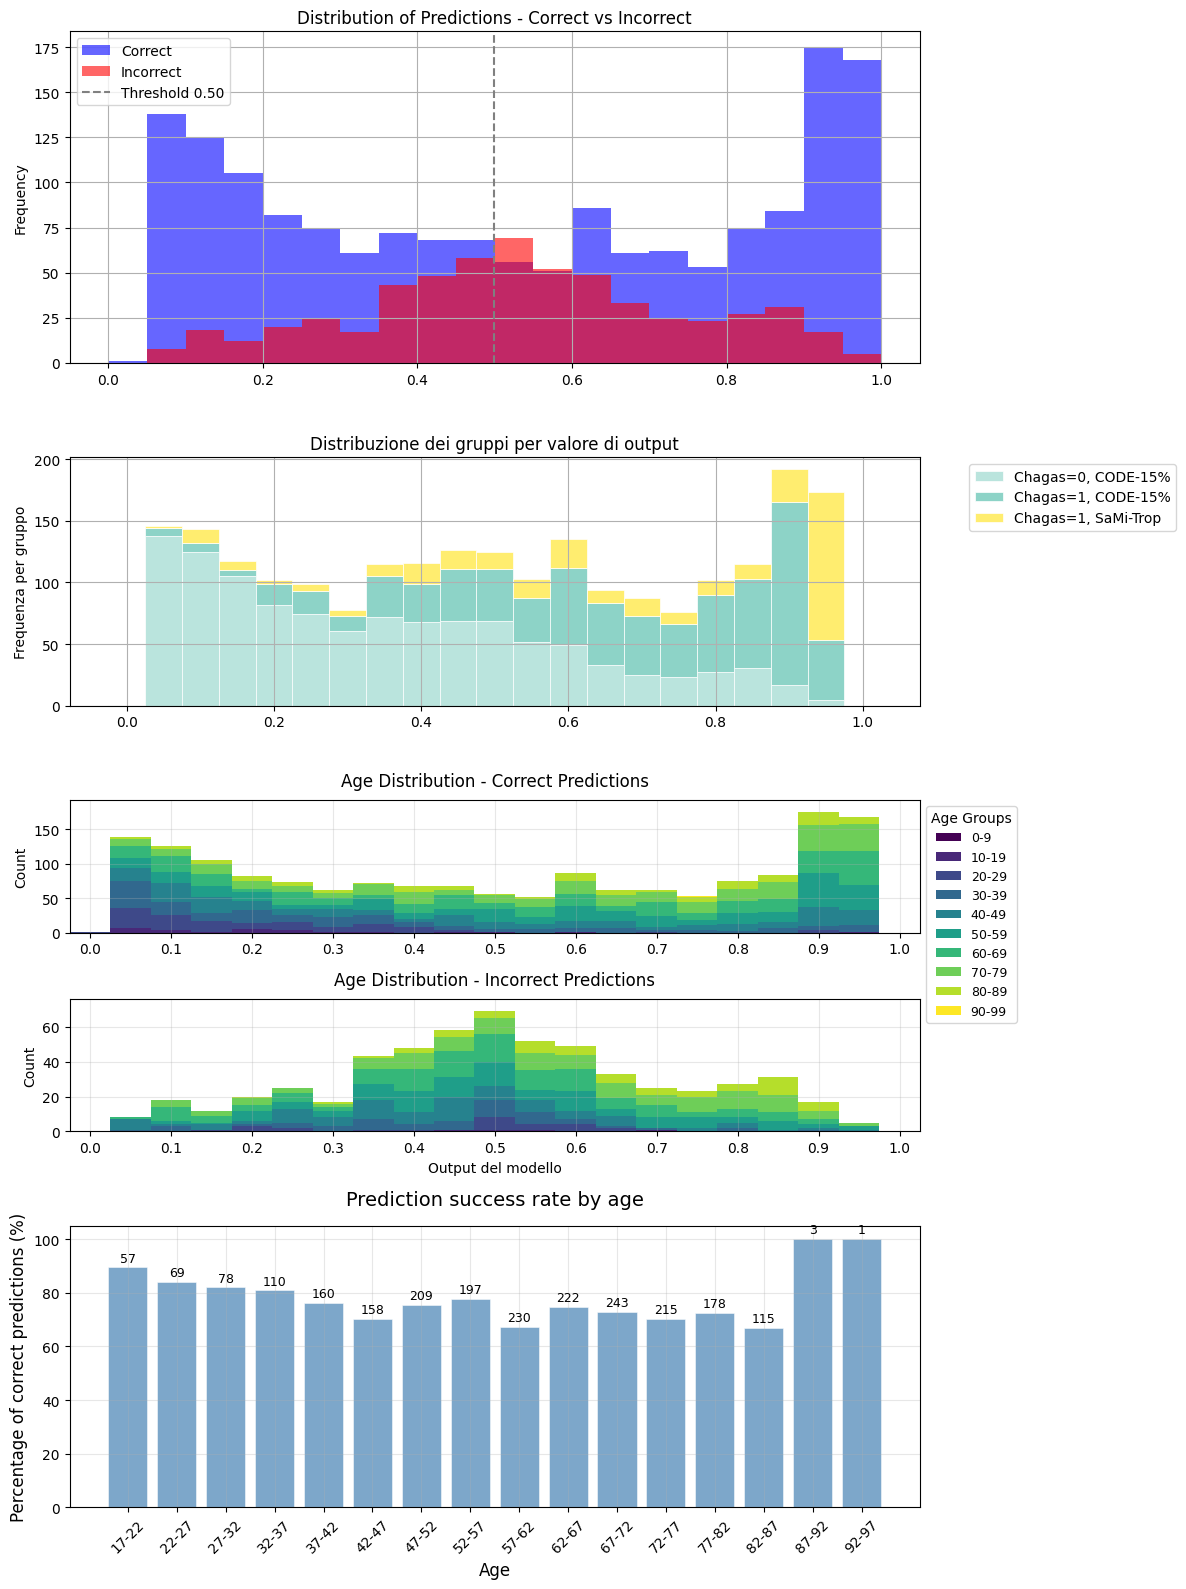

In [ ]:
from models.analysis import plot_model_analysis

plot_model_analysis(model, X_test, y_test, y_test_info, threshold, return_pillow=False)